In [1]:
# Dylan Kriegman / May 2023
# modified by Andrea Miller / Fall 2023
#modified by Jensen Lavering / Fall 2023
# usb port for dynamixel: tty.usbmodem14101

# idea: failutre recovery << screws example


## Start experiment here


In [2]:
# EXPERIMENT STEP (0) - Hardware Discovery
# Call this once to intialize serial connections to ur and gripper
import rtde_control
import rtde_receive
robotIP = "192.168.0.6"
con = rtde_control.RTDEControlInterface(robotIP)
rec = rtde_receive.RTDEReceiveInterface(robotIP)

In [3]:
# EXPERIMENT STEP (0) - Gripper Discovery
# To list serial ports of the motor interface
# $ python -m serial.tools.list_ports
from Motor_Code import Motors
import UR5_Interface as ur
servoPort = "/dev/ttyACM0"
gripperController = Motors(servoPort)
gripperController.torquelimit(600) # used to be 600
gripperController.speedlimit(100)
ur = ur.UR5_Interface()
ur.gripperController = gripperController

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [4]:
# EXPERIMENT STEP (1) - Hardware Interface Initialization
try:
    ur.c = con
    ur.r = rec
    ur.gripperController = gripperController
except Exception as e:
    raise(e)
else:
    print("UR5 + Gripper Interface Established")

UR5 + Gripper Interface Established


In [5]:
ur.openGripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [6]:
# EXPERIMENT STEP (2) - Hardware Test - Raises gripper 1 cm and open's closes gripper
ur.testRoutine()


Running Test Routine
Running UR Test
Running Gripper Test
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Position of dxl ID: 1 set to 549 
Position of dxl ID: 2 set to 490 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [7]:
# EXPERIMENT STEP (3) - Initialize connection to RealSense
import RealSense as real
real = real.RealSense()
real.initConnection()
# real.displayStream()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
# EXPERIMENT STEP (4) - RealSense and YOLO Initialization
# robot_model steps can deleted once extrinsic-free transforms are verfied to be correct
# robot_model = RTB_Model()
# robot_model.setJointAngles(ur.getJointAngles())
import ObjectDetection as ob
try:
    detector = ob.ObjectDetection(real,None,moveRelative = True)
except Exception as e:
    detector.real.pipe.stop()
    raise(e)

In [9]:
# # EXPERIMENT STEP (5) - Image Measurements, Segmentation, and Processing into Blocks
# import Block as bl
# urPose = ur.getPose()
# pcd,rgbdImage = detector.real.getPCD()
# #depthImage,colorImage = rgbdImage.depth,rgbdImage.color
# blocks = detector.getBlocksFromImages(colorImage,depthImage,urPose,display = True)
# for block in blocks:
#      print(f"{block.name}:")
#      print(f"CamFrameCoords: {block.camFrameCoords}")
#      print(f"GripperFrameCoords: {block.gripperFrameCoords}")
#      print(f"WorldFrameCoords: {block.worldFrameCoords}")

In [10]:
# EXPERIMENT STEP (4) - Displaying PCD
# detector.displayWorld(pcd,blocks)


0: 384x640 1 Blue, 1 Red, 2 Yellows, 785.9ms
Speed: 8.9ms preprocess, 785.9ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /home/andreamiller/ris/Independent-Study-Robotics/runs/segment/predict33


Color Image and Depth Image


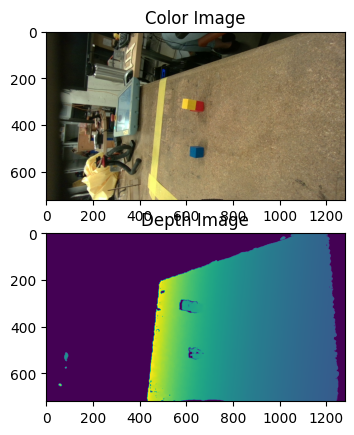

Masks


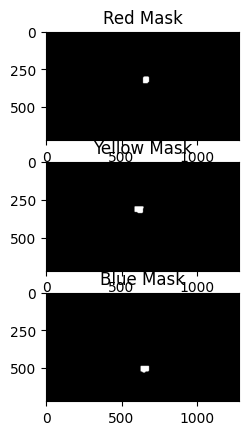

[(1508, PointCloud with 1508 points.)]
[(2111, PointCloud with 2111 points.)]
[(1852, PointCloud with 1852 points.)]
redBlock: [     -410.5     -402.95     -198.63]
yellowBlock: [    -410.88     -407.26     -174.01]
blueBlock: [    -322.54     -389.42     -191.08]
we got here
<<INITIAL WORLD STATE>>
on(yellowBlock,redBlock)
clear(yellowBlock)
on(blueBlock,loc-a)
clear(blueBlock)
on(redBlock,loc-c)
fixed(loc-a)
fixed(loc-b)
clear(loc-b)
fixed(loc-c)
Domain PDDL written to domain.pddl.
Problem PDDL written to problem.pddl.
<<RUNNING FASTDOWNWARD PLANNER>>
INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /home/andreamiller/ris/Independent-Study-Robotics/venv/bin/python3 /home/andreamiller/ris/downward/builds/release/bin/translate/translate.py domain.pddl problem.pddl --sas-file output.sas
Par

In [11]:
# EXPERIMENT STEP (5) - Task Planning

import TaskPlanner as tp
import Block as bl
urPose = ur.getPose()
pcd,rgbdImage = detector.real.getPCD()
depthImage,colorImage = rgbdImage.depth,rgbdImage.color
blocks = detector.getBlocksFromImages(colorImage,depthImage,urPose,display = True)

planner = tp.TaskPlanner(blocks)
goalDict = {"on":[("blueBlock","yellowBlock")]}
steps = planner.generatePlan(goalDict)
print('steps:', steps)
for block in blocks:
    print(f"{block.name} - {list(block.gripperFrameCoords)}")
    print(f"{block.name} - {list(block.worldFrameCoords)}")


In [ ]:
# EXPERIMENT STEP (6) - Grasping blocks at each position in steps, returning to start position, moving to release position, moving back to start, opening gripper
sleepRate = 0.75
def projectToWorldCoords(gripperFrameCoords):
    # given a goal position in gripper coords returns the displacements from the current pose in world coords
    xB,yB,zB = gripperFrameCoords
    # subtract 0.165 from block position in gripper frame to account for gripper length
    zB -= 0.155
    currentPose = ur.getPose() #SE3 Object
    # print(f"Current Pose:\n{currentPose*1000}")
    R = currentPose.R 
    pX,pY,pZ = tuple(currentPose.t)
    # xB,yB,zB here is the block position in the gripper frame which is aligned with the optoforce frame
    P_goal = np.matmul(R,np.array([xB,yB,zB]).T)  # relative position of the block in world coordinates
    print(f"P_goal:\n{P_goal}")
    dX,dY,dZ = tuple(P_goal) # quantities and directions the the gripper frame should be incremented to be centered at the block 
    return dX,dY,dZ
    
def moveToBlock(blockPos):
    # would be better if this was block object
    # :blockPos is coord in gripper frame
    dX,dY,dZ = projectToWorldCoords(blockPos) # goalPose in world coordinates
    homePose = ur.getPose()
    dZ  += 7/1000 # up 7 mm to avoid hitting lower block
    goal1 = copy.deepcopy(homePose)
    goal1.t[2] += dZ
    ur.moveL(goal1)
    time.sleep(sleepRate)
    goal2 = goal1
    goal2.t[0] += dX
    goal2.t[1] += dY
    ur.moveL(goal2)
    time.sleep(sleepRate)
    
def moveBackFromBlock(homePose):    
    currentPose = ur.getPose()
    # Move up 3 mm to avoid raise block to prevent friction from toppling lower block
    goal1 = copy.deepcopy(currentPose)
    goal1.t[2] += 3/1000
    ur.moveL(goal1)
    time.sleep(sleepRate)
    currentPose = ur.getPose()
    dX,dY,dZ = tuple(homePose.t - currentPose.t)
    # Move in the XY Plane then Z Axis
    goal2 = copy.deepcopy(currentPose)
    goal2.t[0] += dX
    goal2.t[1] += dY
    ur.moveL(goal2)
    time.sleep(sleepRate)
    # Move in Z Axis back to home
    goal3 = copy.deepcopy(goal2)
    goal3.t[2] += dZ
    ur.moveL(goal3)
    time.sleep(sleepRate)


    


In [ ]:
import numpy as np
import spatialmath as sm
import copy
import time

goalBlock = blocks[1]
blockLength = 0.02
releaseCoords = goalBlock.gripperFrameCoords + goalBlock.getWorldFrameVerticalInGripper(blockLength)
verticalDist = 0.02
gX,gY,gZ = tuple(goalBlock.urPose.t)
res = np.matmul(goalBlock.urPose.R,(sm.SE3.Trans([gX,gY,gZ+verticalDist]).t - goalBlock.urPose.t))
# print(f"res: {projectToWorldCoords(res)} ")
# ur.openGripper() # Open gripper
# ur.testRoutine()
homePose = ur.getPose()

for step in steps:
    # Grasp and Move Home Step
    grabPos,releasePos = step
    moveToBlock(grabPos) 
    print("Done moving to block")
    ur.closeGripper(9) 
    time.sleep(sleepRate)
    moveBackFromBlock(homePose)
    moveToBlock(releasePos)
    ur.closeGripper(55)
    moveBackFromBlock(homePose)
    ur.openGripper()


In [ ]:
ur.c.disconnect()
ur.r.disconnect()
time.sleep(2)
try:
    robotIP = "192.168.0.6"
    con = rtde_control.RTDEControlInterface(robotIP)
    rec = rtde_receive.RTDEReceiveInterface(robotIP)
    #ur = UR5_Interface() -- commented out since when imported it is defined as ur. if you run this before importing uncommnet --Jensen
    ur.c = con
    ur.r = rec
    ur.gripperController = gripperController
    time.sleep(5)
    ur.testRoutine()
except Exception as e:
    raise(e)
else:
    print("UR5 + Gripper Interface Established")



In [ ]:
planner.locPositions["loc-a"]

In [ ]:
ur.moveL(homePose)

In [ ]:
ur.openGripper()

In [ ]:
ur.moveL(homePose)

In [ ]:
ur.openGripper()

In [ ]:
# MAY WANT TO BREAK THIS UP INTO SEPARATE CELLS
import UR5_Interface as ur 
def runRoutine():
    print("1")
    try:
        #ur = UR5_Interface()
        ur.c = con
        ur.r = rec
        ur.gripperController = gripperController
    except Exception as e:
        raise(e)
        
    print("2")
    # robot_model = RTB_Model()
    # robot_model.setJointAngles(ur.getJointAngles())
    # Set joint angles so object detection has correct extrinsics
    
    # Instantiates ObjectDetection object which intializes a connection to the realsense
    detector = ObjectDetection(robot_model,moveRelative = True)
    
    try:
        
        ur.openGripper()
        print(f"Nth Frame Pose:\n{np.array(ur.getPose())}")
        # Takes images for display
        pcd,rgbdImage = detector.real.getPCD()
        depthImage,colorImage = rgbdImage.depth,rgbdImage.color
        # detector.real.displayImages(depthImage,colorImage)
        
        blocks = detector.getBlocksFromImages(colorImage,depthImage)
        for block in blocks:
            print(f"{block.name}:")
            print(f"CamFrameCoords: {block.camFrameCoords}")
            print(f"GripperFrameCoords: {block.gripperFrameCoords}")
            print(f"WorldFrameCoords: {block.worldFrameCoords}")
        m = MotionPlanner(blocks,moveRelative = True)
        # Interface to the UR5
        m.ur = ur 
        # m.rtb_model = robot_model
        redBlock,yellowBlock,blueBlock = blocks
        redPCD,yellowPCD,bluePCD = redBlock.blockPCD,yellowBlock.blockPCD,blueBlock.blockPCD
        redAABB,yellowAABB,blueAABB = redBlock.blockAABB,yellowBlock.blockAABB,blueBlock.blockAABB,
        detector.real.displayPCD([redPCD,yellowPCD,bluePCD,redAABB,yellowAABB,blueAABB])
        m.runMovement()
        # time.sleep(3)
        # ur.closeGripper(10)
        
    except Exception as e:
        raise(e)
    finally:
        detector.real.pipe.stop()
        # ur.c.disconnect()
        # ur.r.disconnect()
runRoutine()

In [ ]:
ur.c.disconnect()
ur.r.disconnect()

robot_model = RTB_Model()
robot_model.plotRobot()
x,y,z = [],[],[]
for point in redPCD.points:
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])

print(np.mean(x))
print(np.mean(y))
print(np.mean(z))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
plt.show()

In [ ]:
(real.extrinsics is None) == False